## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0


In [4]:
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{c['livetime']}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz


## Datasets

In [5]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    # piece wise model
    # remove old bkg model
    #setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    #setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    #dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    #dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    #setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

    
       
    return dataset_asimov_N, dataset_asimov

In [6]:
datasets_N = []
datasets = []
for n in range(len(livetimes)):
    dataset_asimov_N, dataset_asimov = set_up(dataset_input)
    datasets_N.append(dataset_asimov_N)
    datasets.append(dataset_asimov)

In [7]:
print("read")
for i, d in enumerate(datasets):
    print(i)
    path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
    datasets[i].models = Models.read(path)
for i, d in enumerate(datasets_N):
    print(i)
    path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}.yml'
    print(path)
    datasets_N[i] = Dataset_load.load_dataset_N(d, path,bkg_sys = False)        
    datasets_N[i].models.parameters['tilt'].frozen = False 
    


read
0
1
2
3
4
5
6
7
8
9
10
11
12
0
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_0.01.yml
1
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_0.021544346900318832.yml
2
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_0.046415888336127774.yml
3
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_0.1.yml
4
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_0.21544346900318834.yml
5
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_0.46415888336127775.yml
6
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_1.0.yml
7
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_2.154434690031884.yml
8
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_4.641588833612778.yml
9
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_10.0.yml
10
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_21.544346900318832.yml
11
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_46.41588833612777.yml
12
../Eff_area_PKSflare_crab/data/0_model_nui_livetime_100.0.yml


## RND Fluxpoints

In [8]:
infos = np.loadtxt(f"../{c['folder']}/data/1_P_draw_info.txt")
N_max = 100
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
res_rnds = infos[:N_max, 2]
bias_rnds = infos[:N_max, 3]


pars_N = np.loadtxt(f"../{c['folder']}/data/1_N_P_draw_par.txt")
lives = pars_N[:N_max, -1:]

fpd_Ns, fpd_s = [], []

for i in range(len(shift_rnds)):
    s = shift_rnds[i]
    t = index_rnds[i]
    r = res_rnds[i]
    b = bias_rnds[i]
    rnds = f"{s:.6}_{t:.6}_{r:.6}_{b:.6}"
    l = lives[i][0]
    print(l)
    fluxpoints = FluxPoints.read(
        f"../{c['folder']}/data/fluxpoints/1P_fluxpoints_{l}_{rnds}.fits"
    )
    fluxpoints_N = FluxPoints.read(
        f"../{c['folder']}/data/fluxpoints/1P_fluxpoints_N_{l}_{rnds}.fits"
    )
    model_name = f"../{c['folder']}/data/fluxpoints/1P_model_N_{l}_{rnds}.yaml"
    fluxpoints_Nds = FluxPointsDataset(data=fluxpoints_N, models=Models.read(model_name))
    model_name = f"../{c['folder']}/data/fluxpoints/1P_model_{l}_{rnds}.yaml"
    fluxpoints_ds = FluxPointsDataset(data=fluxpoints, models=Models.read(model_name))
    fpd_Ns.append(fluxpoints_Nds)
    fpd_s.append(fluxpoints_ds)

    


2.154434690031884
2.154434690031884
0.01
0.021544346900318832
0.046415888336127774
0.1
0.21544346900318834
0.46415888336127775
1.0
2.154434690031884
4.641588833612778
10.0
21.544346900318832
46.41588833612777
100.0


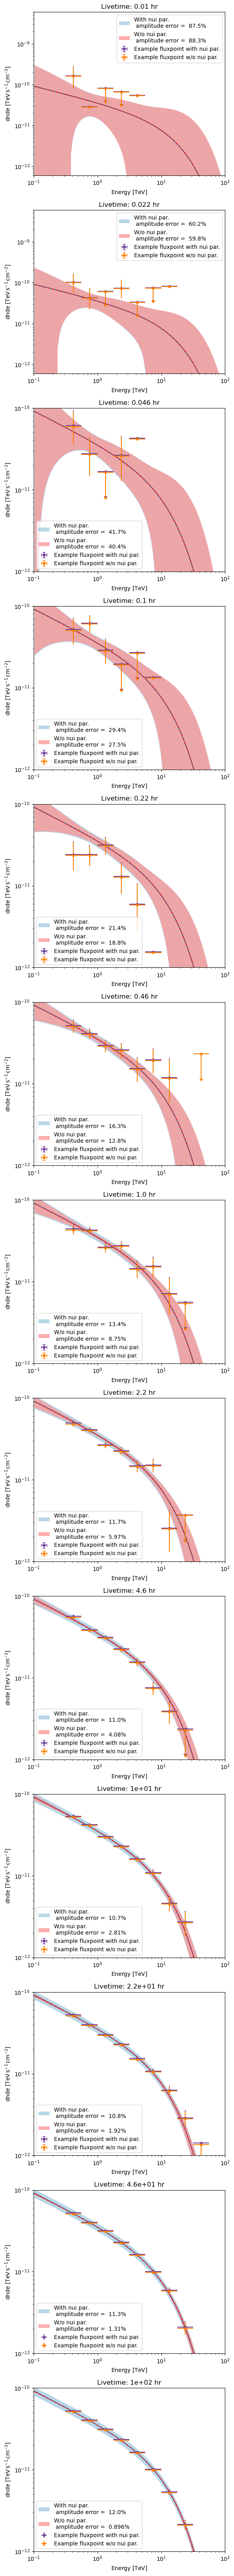

In [9]:
def plot_spectra():
    fig,axs = plt.subplots(len(datasets), 1, figsize = (6, 5 * len(datasets)))
    axs= axs.flatten()
    energy_power = 2
    for i, d in enumerate(datasets):
        ax = axs[i]
        live = livetimes[i]
        dataset = datasets[i]
        dataset_N = datasets_N[i]

        dataset_N.models[0].spectral_model.plot((0.1, 100) *u.TeV, energy_power = energy_power,
                                                     color = aw[0], ax = ax)    
        par = dataset_N.models[0].parameters['amplitude']
        per = par.error /par.value
        dataset_N.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= aw[1], alpha = 0.8, 
                                                     label = f'With nui par.\n amplitude error =  {per*100:.3}% ')
        dataset.models[0].spectral_model.plot((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   color= awo[0], linestyle = 'dashed')
        par = dataset.models[0].parameters['amplitude']
        per = par.error /par.value
        dataset.models[0].spectral_model.plot_error((0.1, 100) *u.TeV,energy_power = energy_power, ax = ax, 
                                                   facecolor= awo[1], alpha = 0.8,
                                                   label = f'W/o nui par.\n amplitude error =  {per*100:.3}%')
        ax.set_title(f"Livetime: {float(live):.2} hr")
        ax.set_ylim(1e-12, 1e-10)

        if i <2:
            ax.set_ylim(6e-13, 6e-9)
            
        
        if live in lives:
            idx = np.where(live == lives)[0][-1]
            fpd_Ns[idx].data.plot(ax = ax, energy_power = energy_power, color = ew[0],
                                 label = "Example fluxpoint with nui par.")
            fpd_s[idx].data.plot(ax = ax, energy_power = energy_power, color = ewo[0],
                                label = "Example fluxpoint w/o nui par.")
        ax.legend()
    plt.tight_layout()
    return fig
        
fig = plot_spectra()
fig.savefig(f'../{folder}/plots/{nbidx}_spectra_with_rnd_fp.pdf')

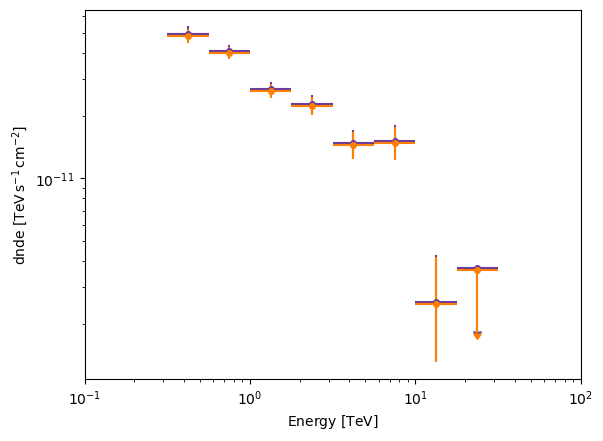

In [10]:
live = lives[0]
energy_power = 2
if live in lives:
    idx = np.where(live == lives)[0][-1]
    fpd_Ns[idx].data.plot( energy_power = energy_power, color = ew[0],
                         label = "Example fluxpoint with nui par.")
    fpd_s[idx].data.plot( energy_power = energy_power, color = ewo[0],
                         label = "Example fluxpoint with nui par.")

In [11]:
fpd_s[idx].models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1,object
spectral,index,2.3691e+00,,8.730e-02,nan,nan,False,False,,None
spectral,amplitude,3.6033e-11,cm-2 s-1 TeV-1,2.315e-12,nan,nan,False,True,,None
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,None
spectral,lambda_,7.6419e-02,TeV-1,3.649e-02,nan,nan,False,False,,None
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,,None
spatial,lon_0,3.2968e+02,deg,2.281e-03,3.287e+02,3.307e+02,False,False,,None
spatial,lat_0,-3.0222e+01,deg,2.036e-03,-3.122e+01,-2.922e+01,False,False,,None


In [12]:
fpd_s[idx].data.dnde_ref.flatten()

<Quantity [4.21967068e-09, 1.07040173e-09, 2.69857382e-10, 6.72906441e-11,
           1.64549969e-11, 3.88656542e-12, 8.63031600e-13, 1.71718173e-13,
           2.81082096e-14, 3.25162667e-15, 2.02905380e-16, 4.22449587e-18] 1 / (cm2 s TeV)>

In [13]:
fpd_Ns[idx].models.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1,object
spectral,index,2.3725e+00,,8.751e-02,nan,nan,False,False,,None
spectral,amplitude,3.6031e-11,cm-2 s-1 TeV-1,4.479e-12,nan,nan,False,True,,None
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,None
spectral,lambda_,7.5821e-02,TeV-1,3.650e-02,nan,nan,False,False,,None
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,,None
spatial,lon_0,3.2968e+02,deg,2.281e-03,3.287e+02,3.307e+02,False,False,,None
spatial,lat_0,-3.0222e+01,deg,2.037e-03,-3.122e+01,-2.922e+01,False,False,,None


In [14]:
fpd_Ns[idx].data.dnde_ref.flatten()

<Quantity [4.24836883e-09, 1.07566861e-09, 2.70691746e-10, 6.73816619e-11,
           1.64511968e-11, 3.88057701e-12, 8.60988668e-13, 1.71317000e-13,
           2.80862814e-14, 3.26300913e-15, 2.05478106e-16, 4.35443471e-18] 1 / (cm2 s TeV)>

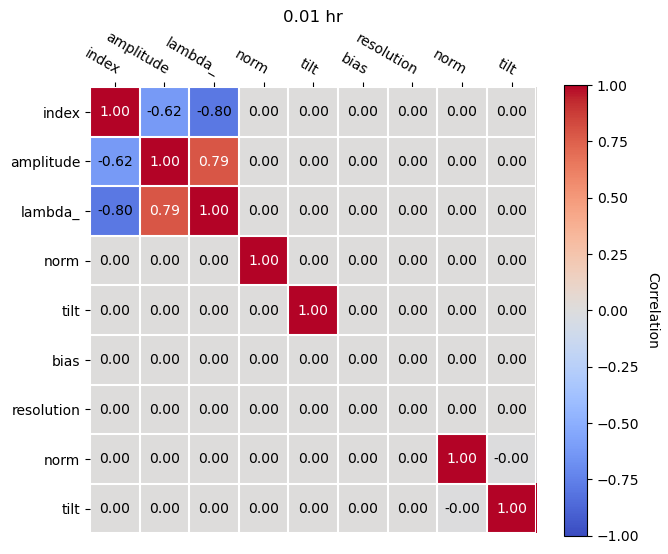

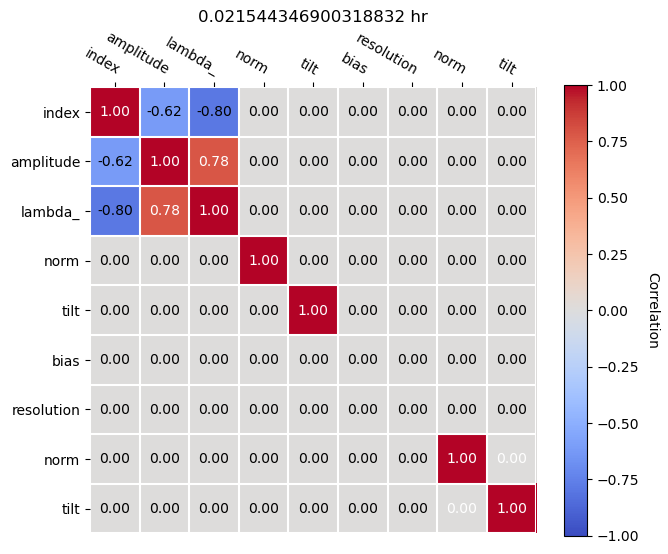

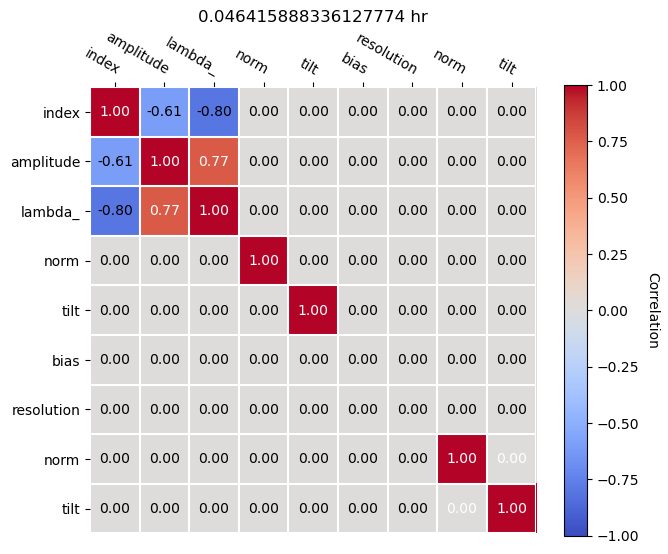

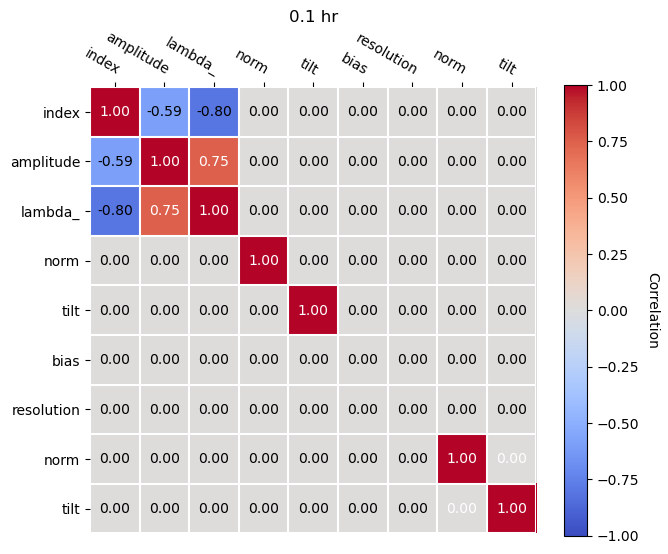

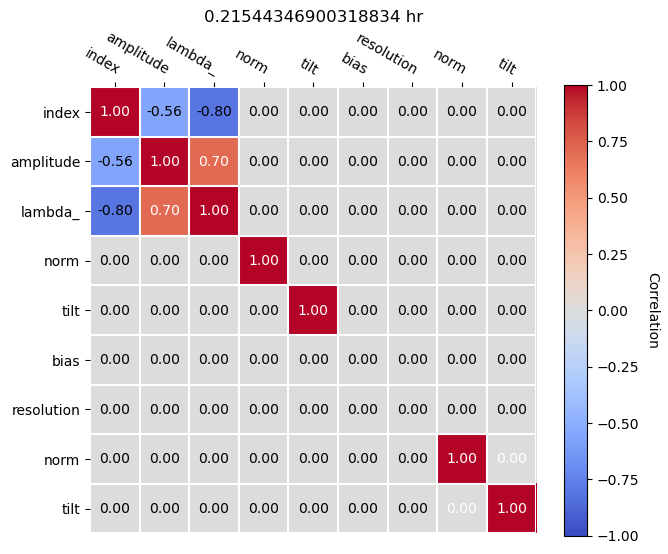

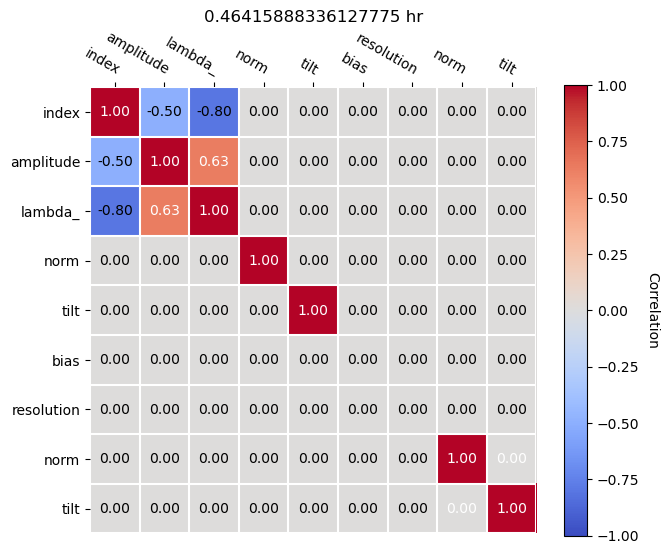

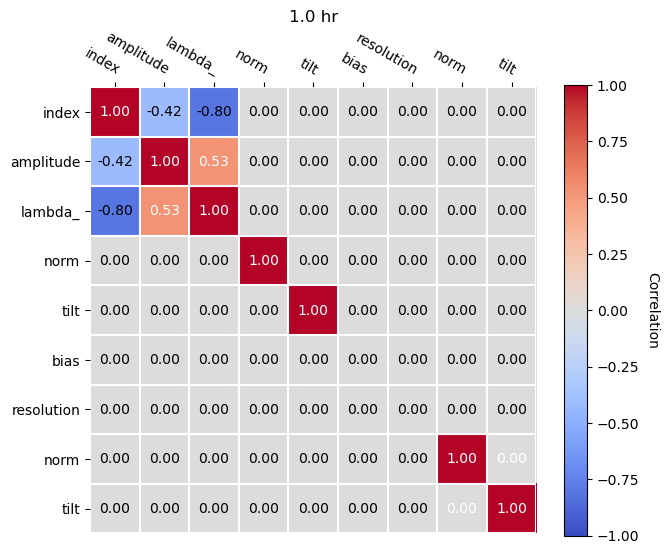

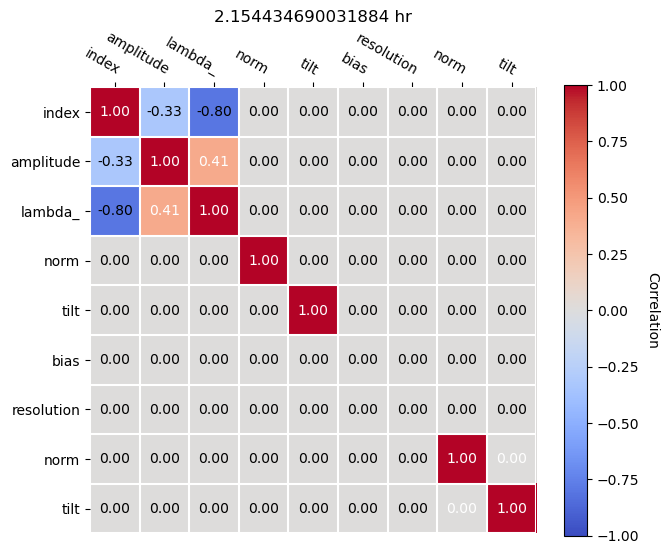

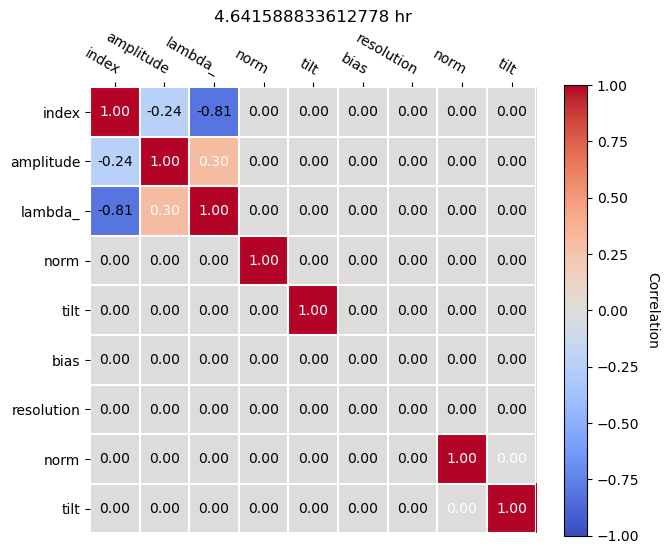

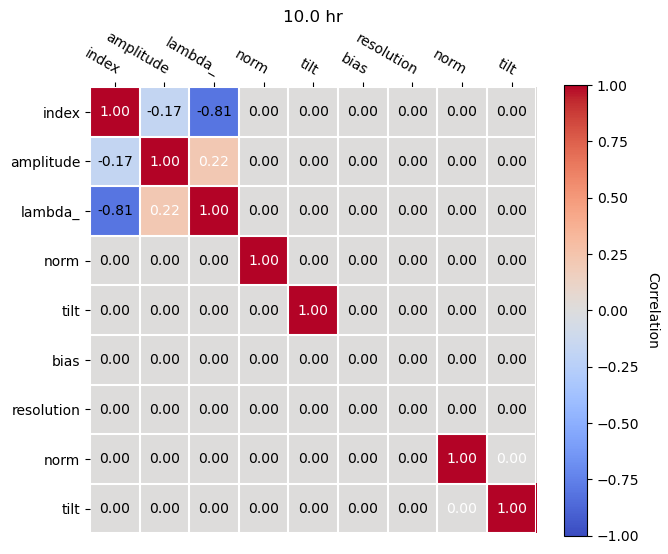

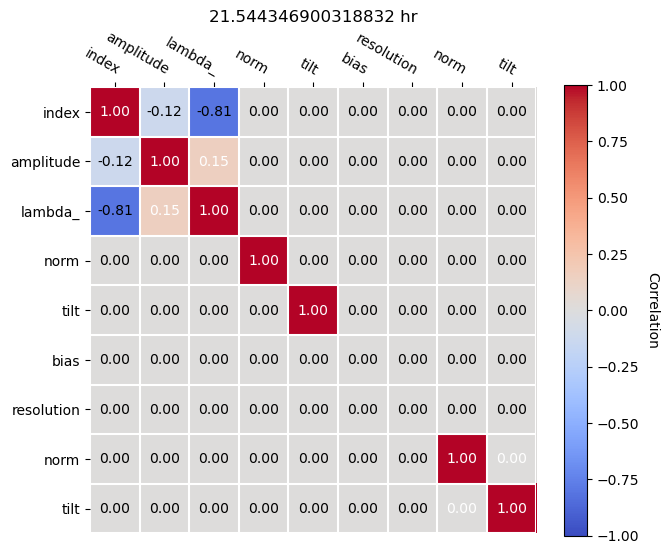

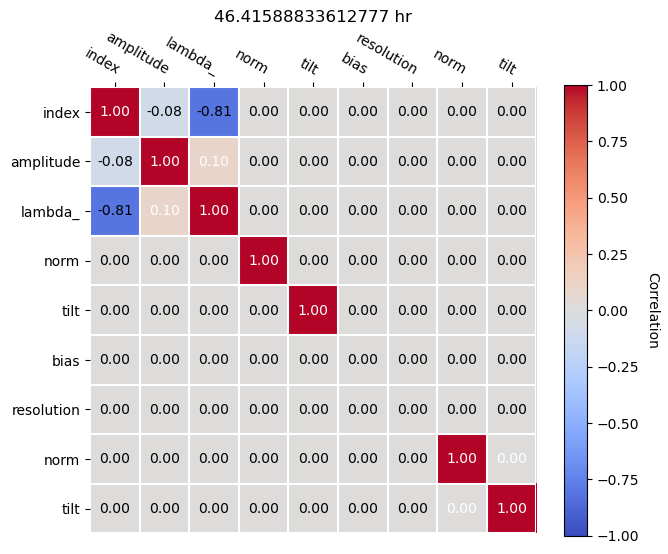

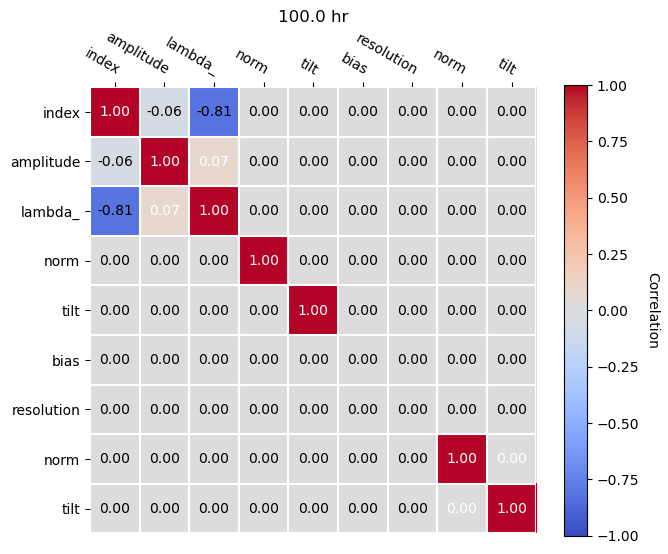

In [16]:
par_names = ['index', 'amplitude', 'lambda_', 'bias', 'resolution', 'norm' , 
            'tilt']
names =  ['index', 'amplitude',  
        'bkg norm', 'bkg tilt',
          'bias', 'resolution',
          'eff. area norm' , 
            'eff. area tilt']
for i in range(len(livetimes)):

    #datasets_N[i].models.read_covariance("data", f"8_model_nui_livetime_{livetimes[i]}_covariance.dat", format="ascii.fixed_width")
    parameters = Parameters([_ for _ in datasets_N[i].models.parameters if _.name in par_names])
    cov_par = datasets_N[i].models.covariance.get_subcovariance(parameters)
    ax = cov_par.plot_correlation()
    ax.set_title(str(livetimes[i]) + " hr")
    fig = plt.gcf()
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.svg')
    fig.savefig(f'../{folder}/plots/{nbidx}_covmatrix_livetime_{livetimes[i]}.pdf')
    
